In [10]:
###import
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import random
import numpy as np
import gym
import time
from gym import spaces
import os
from matplotlib import pyplot as plt
from statistics import mean

## Grid world environment

In [11]:
####################################### GRID WORLD ENV
# custom 2d grid world enviroment
class GridWorld(gym.Env):
    metadata = {'render.modes': ['console']}

    # actions available
    UP = 0
    LEFT = 1
    DOWN = 2
    RIGHT = 3


    def __init__(self, width, height, reward_type="sparse", obstacles=False):
        super(GridWorld, self).__init__()
        self.ACTION_NAMES = ["UP", "LEFT", "DOWN", "RIGHT"]
        self.num_actions = 4

        self.size = width * height  # size of the grid world
        self.num_states = self.size
        self.width = width
        self.height = height
        if obstacles:
            self.num_obstacles = int((width+height)/2)
        else:
            self.num_obstacles = 0
        self.end_state = np.array([height - 1, width - 1], dtype=np.uint8) # goal state = bottom right cell

        # actions of agents : up, down, left and right
        self.action_space = spaces.Discrete(4)
        # observation : cell indices in the grid
        self.observation_space = spaces.MultiDiscrete([self.height, self.width])

        self.obstacles = np.zeros((height, width))

        for i in range(self.num_obstacles):
            self.obstacles[ random.randrange(height) , random.randrange(width)] = 1

        self.num_steps = 0
        self.max_steps = height*width

        self.current_state = np.zeros((2), np.uint8)#init state = [0,0]

        self.directions = np.array([
            [-1,0], #UP
            [0,-1], #LEFT
            [1,0], #DOWN
            [0,1] #RIGHT
        ])

        self.reward_type= reward_type
        
    def transition_function(self, s, a):
        s_prime =  np.zeros((2), np.uint8)
        s_prime = s + self.directions[a,:]

        if s_prime[0] < self.height and s_prime[1] < self.width and (s_prime >= 0).all():
            if self.obstacles[s_prime[0], s_prime[1]] == 0 :
                return s_prime

        return s


    def reward_function(self,s):
        
        r = -1
        
        if self.reward_type == "sparse":
            if (s == self.end_state).all():
                r = 100
        else:
            r = 1 / (np.sum((self.end_state - s))+0.000001)

        return r

    def termination_condition(self, s):
        done = False
        done = (s == self.end_state).all() or self.num_steps > self.max_steps

        return done

    def step(self, action):
        s_prime = self.transition_function(self.current_state, action)
        reward = self.reward_function(s_prime)
        done = self.termination_condition(s_prime)

        self.current_state = s_prime
        self.num_steps += 1

        return self.current_state, reward, done, None

    def render(self):
        '''
            render the state
        '''

        row = self.current_state[0]
        col = self.current_state[1]

        for r in range(self.height):
            for c in range(self.width):
                if r == row and c == col:
                    print("| A ", end='')
                elif r == self.end_state[0] and c == self.end_state[1]:
                    print("| G ", end='')
                else:
                    if self.obstacles[r,c] == 1:
                        print('|///', end='')
                    else:
                        print('|___', end='')
            print('|')
        print('\n')



    def reset(self):
        self.current_state = np.zeros((2), np.uint8)
        self.num_steps = 0

        return self.current_state

    def close(self):
        pass
    
    
class NonDeterministicGridWorld(GridWorld):
    def __init__(self, width, height, p=0.8, reward_type="sparse", obstacles=False):
        super(NonDeterministicGridWorld, self).__init__(width, height, reward_type, obstacles)
        self.probability_right_action = p

    def transition_function(self, s, a):
        s_prime = s + self.directions[a, :]

        #with probability 1 - p diagonal movement
        if random.random() <= 1 - self.probability_right_action:
            if random.random() < 0.5:
                s_prime = s_prime + self.directions[(a+1)%self.num_actions, :]
            else:
                s_prime = s_prime + self.directions[(a-1)%self.num_actions, :]


        if s_prime[0] < self.height and s_prime[1] < self.width and (s_prime >= 0).all():
            if self.obstacles[s_prime[0], s_prime[1]] == 0 :
                return s_prime

        return s


# Q learning

## Q function evluation

In [12]:

def evaluate_q_table(env, q_table, n_episodes=10, render=False):
    cum_rews = []
    for ep in range(n_episodes):
        if render:
            print("################## Episode ",ep+1)
        cum_rew = 0
        done = False
        state =env.reset()
        while not done:
            action = np.argmax(q_table[state[0], state[1]]) # Exploit learned values
            ############## simulate the action
            state, reward, done, info = env.step(action) 
            if render:
                print(env.ACTION_NAMES[action])
                env.render()
                print(done)
            cum_rew += reward
        cum_rews.append(cum_rew)
    mean_rew = mean(cum_rews)
    if render:
        print("Mean reward obtained in {} episodes: {} ".format( n_episodes, mean_rew))
    return mean_rew



## Q learning

In [13]:
def q_learning(env, alpha=1.0, gamma=0.99, initial_epsilon=1.0, n_episodes=10000):
    ####### Hyperparameters
    # alpha = learning rate
    # gamma = discount factor
    # initial_epsilon = initial epsilon value
    # n_episodes = number of episodes

    ############# define Q table and initialize to zero
    # Q size = (state_var1_size , ..., state_varN_size, action_size)
    q_table_size = []
    for size in env.observation_space.nvec:
        q_table_size.append(size)
    
    q_table_size.append(env.action_space.n)
    print("Q table size: ", q_table_size)
    
    q_table = np.zeros(q_table_size)
    
    # init epsilon
    epsilon = initial_epsilon

    received_first_reward = False
    
    #evaluation
    evaluation_rewards = []
    mean_evaluation_rewards = []
    window = 100
    
    for ep in range(n_episodes):
        state = env.reset()
        done = False
        while not done:
            ############## choose the action with epsilon-greedy strategy
            if random.random() < epsilon:
                #print("exploration")
                action = env.action_space.sample() # Explore action space
            else:
                #print("exploitation")
                action = np.argmax(q_table[state[0], state[1]]) # Exploit learned values
            
            ############## simulate the action
            next_state, reward, done, info = env.step(action) 
            #env.render()

            ############## update q table
            old_value = q_table[state[0],state[1], action]
            next_max = np.max(q_table[next_state[0],next_state[1]])
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * (1-done) * next_max)
            q_table[state[0],state[1], action] = new_value

            if not received_first_reward and reward > 0:
                received_first_reward = True
                print("Received first reward at episode ", ep)
            #update current state
            state = next_state
            
        #update current epsilon
        if received_first_reward:
            epsilon= 0.9999*epsilon
            
        #evaluate policy
        evaluation_rewards.append( evaluate_q_table(env, q_table, n_episodes=5) )
        mean_evaluation_rewards.append(mean(evaluation_rewards[-window: ]))
        

    plt.plot(mean_evaluation_rewards)
    
    print("Training finished in {} episodes\n".format(n_episodes))
    return q_table


## test 

In [14]:
#define the env
env = NonDeterministicGridWorld(5,5, reward_type="sparse")


In [15]:
# random exploration
done = False
env.reset()
while not done:
            action = env.action_space.sample() # Explore action space

            print(env.ACTION_NAMES[action])
            ############## simulate the action
            next_state, reward, done, info = env.step(action) 
            print(done)
            print(reward)
            env.render()

LEFT
False
-1
| A |___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___| G |


UP
False
-1
| A |___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___| G |


DOWN
False
-1
|___|___|___|___|___|
| A |___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___| G |


UP
False
-1
| A |___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___| G |


RIGHT
False
-1
|___| A |___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___| G |


RIGHT
False
-1
|___|___| A |___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___| G |


UP
False
-1
|___|___| A |___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___| G |


RIGHT
False
-1
|___|___|___| A |___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___| G

Q table size:  [5, 5, 4]
Received first reward at episode  22
Training finished in 100 episodes



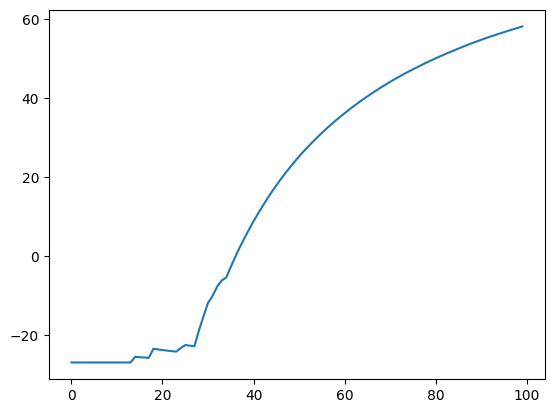

In [16]:
## Q learning
q_table = q_learning(env, alpha=0.2, initial_epsilon=0.8, n_episodes=100)


In [17]:
#print q values
for action in range(env.action_space.n):
    print("Q(s, a={})".format(action))
    print(q_table[:,:,action])

Q(s, a=0)
[[14.11341184  7.87437908 10.67590018 17.78159622 12.54060647]
 [17.20782562 19.13141853 23.07352829 18.1506973  25.42710233]
 [ 6.8108359  17.70489927 22.24873073 37.11070612 48.14920958]
 [-1.29021106  5.82680657 25.65448039 21.11847619 47.12534887]
 [ 3.8697085   5.20309814 19.83253866 32.91323397  0.        ]]
Q(s, a=1)
[[16.4345943  13.21987737  2.83731363 12.25579298 12.71697947]
 [17.55072359 22.44063301 17.5868876  17.33291444 33.9517074 ]
 [ 0.84213766  5.53028937 16.80059938 32.86579849 59.46403174]
 [-0.78019886  0.75625114  4.95470601 16.5051513  60.1771041 ]
 [-1.81975309 -1.59438333  0.12413921  6.00258029  0.        ]]
Q(s, a=2)
[[25.0266827  23.27713567 36.35585838 32.44956808 48.5537056 ]
 [ 4.93745768 21.82403627 46.81864206 57.71429628 69.65824557]
 [ 2.812447   21.6183588  26.72438592 45.09933571 79.54292307]
 [-1.57292033  6.29382566 30.04740239 63.03437978 94.80522532]
 [-1.92484603  1.10079445  7.32757162 27.31701489  0.        ]]
Q(s, a=3)
[[16.6321006

## Evaluate policy

## Render the agent behaviour

In [18]:
mean_cum_rew = evaluate_q_table(env, q_table, render=True) 

################## Episode  1
DOWN
|___|___|___|___|___|
| A |___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___| G |


False
RIGHT
|___|___|___|___|___|
|___| A |___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___| G |


False
RIGHT
|___|___|___|___|___|
|___|___| A |___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___| G |


False
RIGHT
|___|___|___|___|___|
|___|___|___| A |___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___| G |


False
DOWN
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___| A |___|
|___|___|___|___|___|
|___|___|___|___| G |


False
RIGHT
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___| A |
|___|___|___|___|___|
|___|___|___|___| G |


False
DOWN
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___| A |
|___|___|___|___| G |


False
DOWN
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___